<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Homework 03 - Diffusion Maps</div><br>
    <div style="font-size: large">José Antonio Álvarez Ocete</div>
    <div style="font-size: large">Francisco Javier Saez Maldonado</div><br></div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used.

In [3]:
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import pairwise_distances
from sklearn.utils.extmath import svd_flip
from sklearn.gaussian_process.kernels import RBF as rbf_kernel
from typing import Callable, Optional, Union, Type
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.datasets import make_blobs, make_swiss_roll, make_s_curve

from mpl_toolkits.mplot3d import Axes3D

matplotlib.rc('figure', figsize=(15, 5))

seed = 123
my_cmap = plt.cm.Spectral

# Introduction

This practical assignment is about implementing the manifold learning method **Diffusion Maps**, following the *scikit-learn* template for manifold learning algorithms.

We will design two main functions: one for training the algorithm, obtaining the affinity matrix and the embedded coordinates, and a second one for extending these coordinates for new patterns.

# Requirements

The objective of this assignment is to complete the class DM sketched below, which should contain at least the following methods.

`__init__(self, sigma, n_components, step=1, alpha=1)`

* This is the construction method for the class, with the following parameters:
    * `sigma`: Kernel parameter for the Gaussian kernel.
    * `n_components`: dimension of the embedding.
    * `step`: step in the Markov Chain.
    * `alpha`: density influence. It should take a value in `[0,1]`.
* This method just store the parameters in the fields of the class, to be used when needed.

`fit(self, X, y=None)`

* This is the training method, the one that performs the Diffusion Maps algorithm. 

* This method should store the affinity matrix and also the eigenvectors to compute the transformation.

`fit_transform(self, X, y=None)`

* This method returns the embedding coordinates for the training data.
* It should also store the affinity matrix and the coordinates needed to compute the transformation (for example over new, unseen patterns).

`transform(self, X)`

* This method will obtain approximated coordinates for new, unseen data points. 
* It uses for this purpose the Nyström Formula.

## Some recommendations

* It should allow to fix all the DM possibilities (different steps, density normalization...). To allow a change in the kernel function could be also a nice idea.
* Implement all the auxiliary functions that you may need, for example, for deciding the best parameter values in each case.
* It could be a nice idea to offer a deterministic output, that do not depend on the sign of the eigenvectors.

# Implementation

<div class="qst">

* Complete the `DM` class below, satisfying the described requirements.

</div>

## Implementation details

##### Eigenvectors signs

In order to offer a deterministic output, once we compute the eigenvectors we use Sklearn's function `svd_flip()` to obtain a deterministic sign on these vectors. This will allow us to better compare experiment results.


##### Density normalization

The parameter $\alpha$ is used to apply *density normalization* to our affinity matrix $K$. This is a two step process:

1. Normalize the kernel matrix:

$$
    k_{ij}^{(\alpha)} = \frac{k_{ij}}{d_i^\alpha d_j^\alpha}
$$

2. Compute the normalized probability matrix using the recalculated distance values $d_i^{(\alpha)}$:

$$
    p_{ij}^{(\alpha)} = \frac{k_{ij}^{(\alpha)}}{d_i^{(\alpha)}}
$$

This normalization is applied inside the `_compute_probability_matrix()` function, which returns the normalized affinity matrix $K^{(\alpha)}$, the normalized probability matrix $P^{(\alpha)}$ and the normalized distancia matrix $D^{(\alpha)}$.

##### Nystrom formula

In order to implement Nystrom formula we need to compute the new kernel matrix $K(X', X)$, and the associated probability matrix. However, the probability matrix needs to be normalized using $D$, which required the following $4$ submatrices

$$
    K = \begin{pmatrix}
        K(X, X) & K(X, X') \\
        K(X', X) & K(X', X')
    \end{pmatrix}
$$

and not only $K(X', X)$. Since the affinity matrix $K(X, X)$ was already computed in the `fit()` step, only the matrices $K(X', X)$ and $K(X', X')$ are required, and the whole new affinity matrix is manully built.

From this new affinity matrix, the probability matrix (with its own regularization) is created using the method `_compute_probability_matrix()`. Finally, the new set of (column) eigenvectors is computed using Nystrom formula:

$$
    \psi_j(\mathbf x) = \frac{1}{\lambda_j} \sum_{i=0}^N P(\mathbf x, \mathbf x^{(i)}) \cdot \phi_j(\mathbf x^{(i)})
$$

where $\psi_j(\mathbf x)$ is the value of the $j$-th new eigenvector for the test sample $\mathbf x$, $\phi_j(\mathbf x^{(i)})$ is the value of the $j$-th original eigenvector for the $i$-th training sample. This formula can be vectorized as follows:

$$
    \psi_j = \frac{1}{\lambda_j} \langle P(\mathbf X', \mathbf X) \; , \; \phi_j \rangle
$$

In [4]:
a = np.array([[0.5,0.5],[0.25,0.25]])
print(a)
a.sum(axis = 0)

[[0.5  0.5 ]
 [0.25 0.25]]


array([0.75, 0.75])

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin


class DM(TransformerMixin, BaseEstimator):
    """
        Diffusion Maps.
    """

    def __init__(self,
                 kernel: Union[str, Callable[[
                     np.ndarray, np.ndarray], np.ndarray]] = 'rbf',
                 sigma: Union[str, float] = 'percentile',
                 n_components: int = 2,
                 step: int = 1,
                 alpha: float = 1.0,
                 percentile: float = 50):
        """
        Initializes the Difussion Map object
        ----------
        X : sigma

        ...

        rho : the percentile used for optimal sigma obtention
        Returns
        -------
        self : returns an instance of self.
        """
        # Assignment of the hyper-parameters
        self.sigma = sigma
        self.n_components = n_components
        self.step = step
        self.alpha = alpha
        self._kernel = kernel
        self.percentile = percentile
        # Raise variables
        self._fitted = False
        self._fixed_sigma = False

    def _determine_sigma(self):
        """
        Converts string sigma values to actual float sigma values
        """
        if self.sigma == 'median':
            self.sigma = np.percentile(pairwise_distances(self.X), 50)
        elif self.sigma == 'maximum':
            self.sigma = np.percentile(pairwise_distances(self.X), 100)
        elif self.sigma == 'percentile':
            self.sigma = np.percentile(
                pairwise_distances(self.X), self.percentile)

        self._fixed_sigma = True

    def _determine_kernel(self):
        """
        Converts kernel value to final kernel
        """
        if not self._fixed_sigma:
            raise ValueError("Sigma has not been fixed yet")

        if self._kernel in ['auto', 'rbf']:
            # Recall that this rbf_kernel is the one from
            # Gaussian procesess, which receives sigma as parameter
            self._kernel = rbf_kernel(self.sigma)

        elif self._kernel == 'laplacian':
            self._kernel = lambda X, y = None: laplacian_kernel(
                X, y, gamma=1/(2*self.sigma_**2))

    def _compute_probability_matrix(self, K):
        # Compute the distance matrix and raise it to alpha
        D = np.sum(K, axis=0)**self.alpha

        # Apply density normalization
        K_alpha = K / D / D.T


        # Re-compute the distance matrix using the normalized K
        D_alpha = K_alpha.sum(axis=0).reshape(-1,1)
        
        # Compute the probability matrix by dividing each row.
        P = K_alpha / D_alpha
        
        return P, D_alpha, K_alpha

    def fit(self, X, y=None):
        """
        Compute the embedding vectors for data X
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        self : returns an instance of self.
        """
        # Save data
        self.X = X

        # Determine sigma to use
        self._determine_sigma()
        self._determine_kernel()

        # Instantiate the kernel and compute the affinity matrix
        K = self._kernel(X, X)
        self._affinity_matrix = K

        # Compute affinity matrix applying density normalization
        P, D, K = self._compute_probability_matrix(K)

        # Compute stationary distribution
        pi = D / np.sum(D)

        # Compute the conjugate of the P matrix
        D_sqrt = np.sqrt(D)
        A = K / D_sqrt
        A = A / D_sqrt.T

        # Obtain the SVD decomposition of the conjugate matrix
        # Remember that eigenvecs has the eigen-vectors as its columns!
        eigenvecs, eigenvals, V = np.linalg.svd(A, full_matrices=True)

        # Make the eigenvector signs match the ones obtained from Sklearn
        eigenvecs, _ = svd_flip(eigenvecs, V)

        # Normalize eigenvectors
        #eigenvecs = eigenvecs / np.sqrt(pi)
        

        # Remove first component, with eigenvalue 1
        # Recall that we are assuming that the eigenvals/vecs are sorted!
        # n_components + 1 since we are already not considering 1st position
        self.eigenvecs = eigenvecs[:, 1:self.n_components + 1]
        self.eigenvals = eigenvals[1:self.n_components + 1]

        # Update fitted state
        self._fitted = True
        return self

    def fit_transform(self, X, y=None):
        """Compute the embedding vectors for data X and transform X.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        self.fit(X)
        return (self.eigenvals**self.step) * self.eigenvecs

    def _expand_affinity_matrix(self, X_prime):
        K_crossed = self._kernel(X_prime, self.X)
        K_prime = self._kernel(X_prime, X_prime)
        K_1 = np.vstack([self._affinity_matrix, K_crossed])
        K_2 = np.vstack([K_crossed.T, K_prime])
        return np.hstack([K_1, K_2])

    def transform(self, X):
        """Transform X.
        This function is implemented using the Nyström formula.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features).
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """

        if not self._fitted:
            raise ValueError(' The model has not been fitted yet. Aborting.')
        # Compute the extended affinity matrix
        K_prime = self._expand_affinity_matrix(X)

        # Compute the extended probability matrix
        P_prime, _, _ = self._compute_probability_matrix(K_prime)

        # Extract P(X', X) from the whole P_prime
        P_crossed = P_prime[len(self.X):, :len(self.X)]

        # Iterate through the eigenvectors (stored as columns) to
        # obtain the new eigenvectors. Finally, store them as columns.
        new_eigenvecs = np.array([
            1.0 / lamb * P_crossed @ v.T
            for v, lamb in zip(self.eigenvecs.T, self.eigenvals)
        ]).T

        return new_eigenvecs

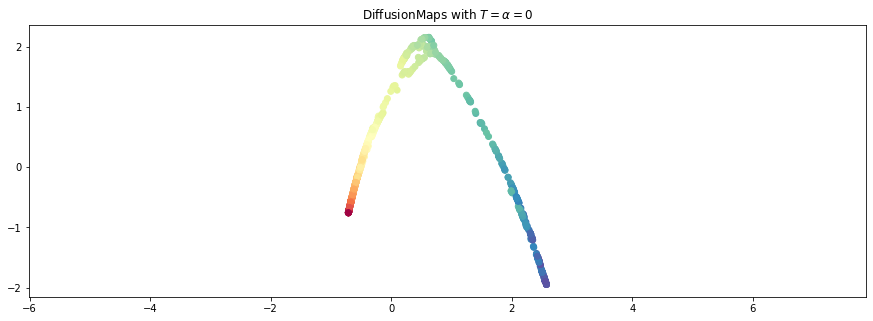

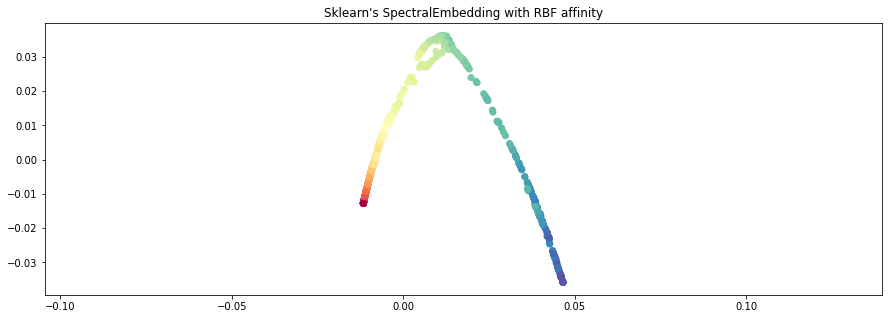

In [60]:
N = 1000
X, color = make_swiss_roll(N, random_state=seed)

dm = DM(n_components=2, sigma= 1.0, step=0, alpha=0)
X_red = dm.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.title(r"DiffusionMaps with $T=\alpha=0$")
plt.show()




from sklearn.manifold import SpectralEmbedding

se = SpectralEmbedding(affinity='rbf', gamma=0.5)
X_red_sk = se.fit_transform(X)

plt.scatter(X_red_sk[:, 0], X_red_sk[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.title("Sklearn's SpectralEmbedding with RBF affinity")
plt.show()



In [44]:
def scatter_2D(X, y, title=""):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
    #ax.axis('equal')
    ax.set_title(title)
    plt.show()


def scatter_3D(X, y, title=""):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
    ax.set_title(title)
    plt.show()

# Experiments with DM

<div class="qst">

* Obtain some good embedded coordinates for the three training datasets specified below.
    
* Extend its coordinates for the new points.
    
</div>

It is known that Difussion Maps need the data to be standardized. We declare a scaler from `Sklearn` and we will use it  in the incoming cells (fitting it in each case).

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## Dataset 1: two blobs

Let us begin with the simplest dataset. It consists of two blobs of points, each one corresponding to one class.

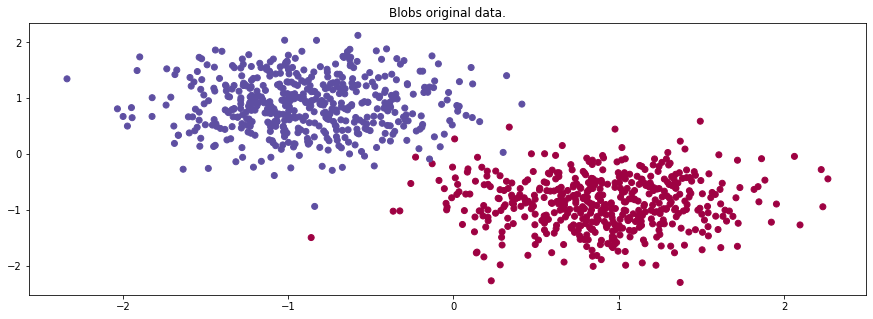

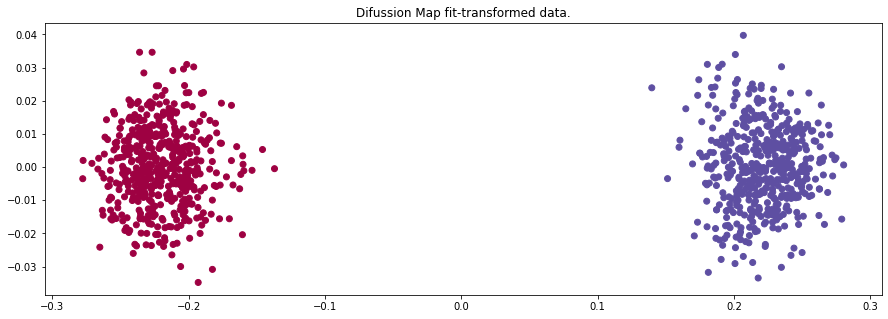

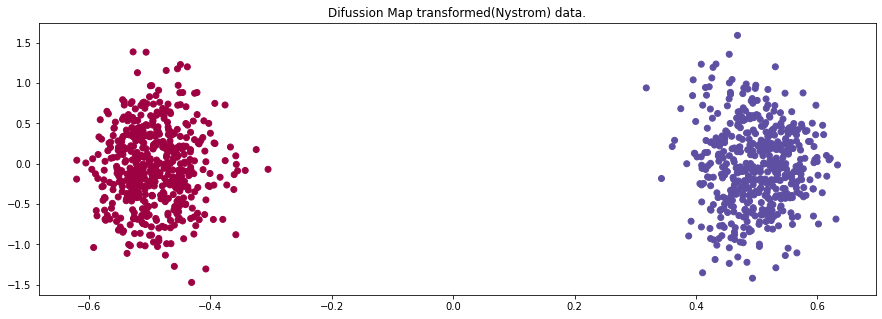

In [54]:
# Dataset creation
N = 1000
X, y = make_blobs(n_samples=N, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed)
y[y != 1] = -1
# Scale data and plot
X = scaler.fit_transform(X)
scatter_2D(X, y, title="Blobs original data.")


# Model definition
dm = DM()

# Transformation and plot
X_transformed = dm.fit_transform(X)
X_transformed_nystrom = dm.transform(X)
scatter_2D(X_transformed, y, title="Difussion Map fit-transformed data.")
scatter_2D(X_transformed_nystrom, y,
           title="Difussion Map transformed(Nystrom) data.")

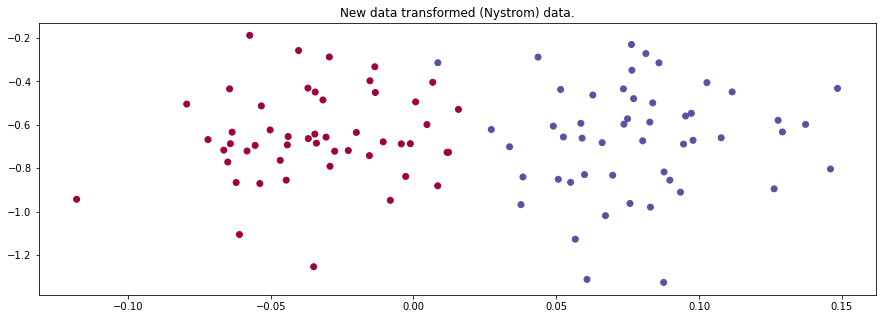

In [10]:
# Create new data
N_new = 100
X_new, y_new = make_blobs(n_samples=N_new, n_features=50, centers=2,
                          cluster_std=3.0, random_state=seed+1)

# Transform new data
X_new = scaler.transform(X_new)
X_new_transformed = dm.transform(X_new)

scatter_2D(X_new_transformed, y_new,
           title="New data transformed (Nystrom) data.")

## Dataset 2: the swiss roll

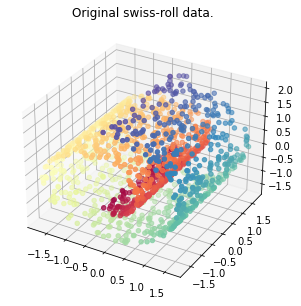

In [55]:
N = 1500
X, color = make_swiss_roll(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)


scatter_3D(X, color, title="Original swiss-roll data.")

15.427028142594567


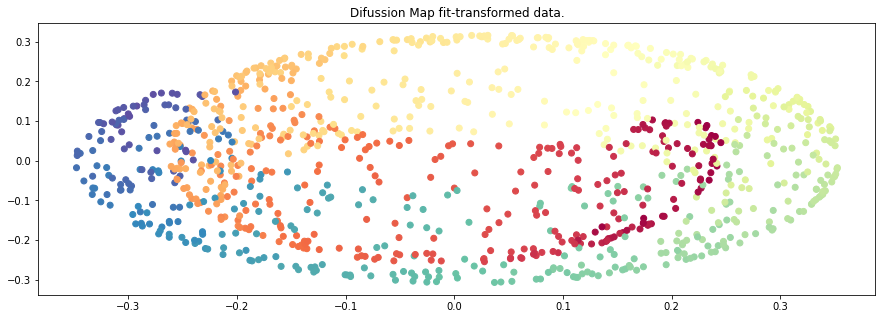

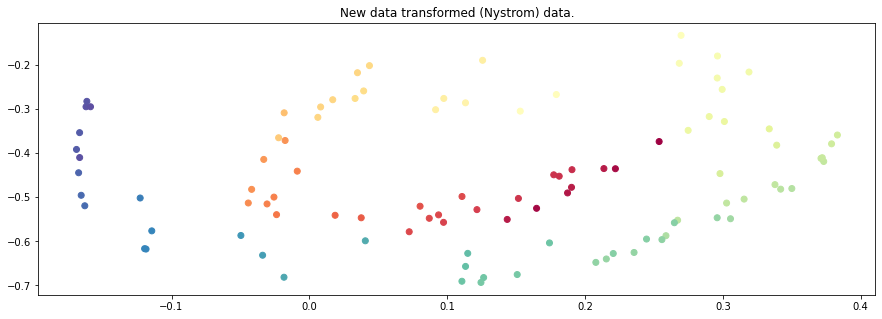

In [67]:
# Model definition
dm = DM()

# Transformation and plot
X_transformed = dm.fit_transform(X)
print(dm.sigma)
scatter_2D(X_transformed, color, title="Difussion Map fit-transformed data.")

N_new = 100
X_new, color_new = make_swiss_roll(n_samples=N_new, random_state=seed+1)


# Transform new data
X_new = scaler.transform(X_new)
X_new_transformed = dm.transform(X_new)

scatter_2D(X_new_transformed, color_new,
           title="New data transformed (Nystrom) data.")

## Dataset 3: the S curve

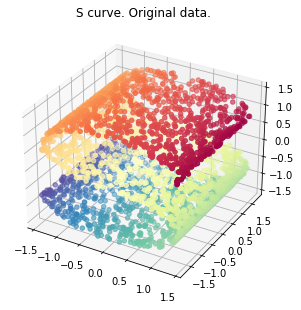

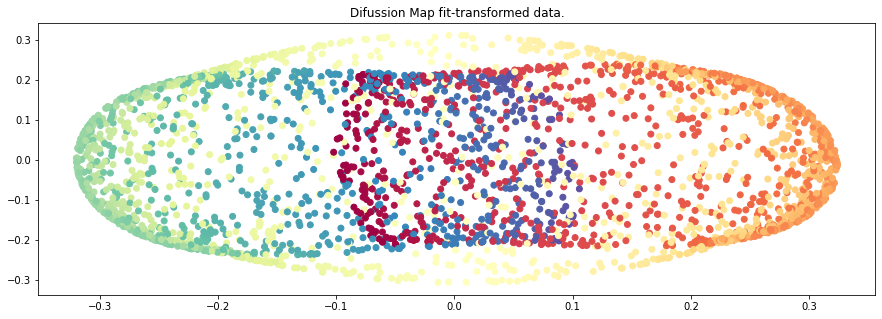

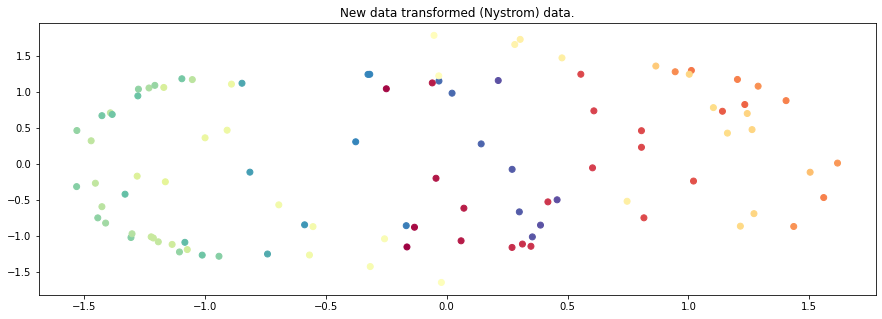

In [12]:
N = 3000
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)

scatter_3D(X, color, title="S curve. Original data.")

# Model definition
dm = DM()

# Transformation and plot
X_transformed = dm.fit_transform(X)
scatter_2D(X_transformed, color, title="Difussion Map fit-transformed data.")

N_new = 100
X_new, color_new = make_s_curve(N_new, random_state=seed+1)
X_new = scaler.transform(X_new)

X_new_transformed = dm.transform(X_new)

scatter_2D(X_new_transformed, color_new,
           title="New data transformed (Nystrom) data.")

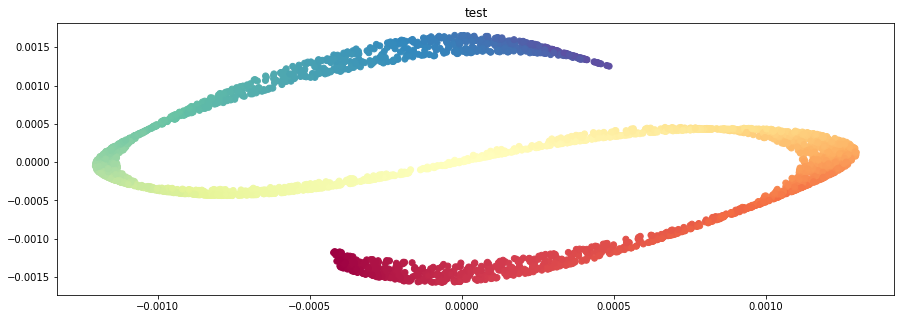

In [13]:
from sklearn.manifold import SpectralEmbedding

se = SpectralEmbedding(affinity='rbf', gamma = 0.5 )
se_red_sk = se.fit_transform(X)

scatter_2D(se_red_sk,color, title = "test")

<div class="qst">

1. Do you consider that the embedding obtained is good for the previous datasets? Is it the expected one? Why?
    
    
2. How sensible is the method to its hyper-parameters? Specify the best values that you have found and the technique employed for it.
    * Check how much influence the sample density (you can vary N for each dataset).
    * Check what happens if the number of steps `steps` grows.
   
    
3. In your opinion, which is the main advantage and disadvantage of this method?
    
</div>

**Answer**:




TODO:
- [x] Normalizar los datos
- [x] Seleccion de parametro sigma (de RBF) utilizando las formulas que ponen ellos. Como sigma tiene que ser mayor que 0 podemos poner que si dan el parametro = -1, tomamos nosotros el optimo o algo asi, calculandolo a partir de los datos. **Discutir qué es lo que queremos hacer**
2. lo que pone justo en la celda de arriba, `Some recommendations`:
- [x] El tercer punto ya está hecho
- [x] Poner un kernel cualquier (como dijimos en clase, pasándoselo instanciado)
3. Hacer experimentos de abajo

Nota final: variando el alpha de la normalizacion no he entendido por que cambia absoultamente nada (un poco en los ejes pero las formas son todas iguales). No estoy seguro de que este bien implementado aunque no parece dificil la verda. Quizás al hacer experimentos con el resto de datasets se vea mejor.
